In [1]:
#import matplotlib
#matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white") 
# display plots in this notebook
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np


In [64]:
def Loops_Return_two_bins_no_dup(df_hic):
    # verified on 03/04/2021
    ## Associated by promoter
    second_bin_columns = [3,4,5,0,1,2]+list(range(6,len(df_hic.columns),1))
    df_hic=df_hic.append(pd.DataFrame(df_hic.iloc[:, second_bin_columns].values, columns=df_hic.columns)) ## union left and right bin
    ### Sort by coordinate
    return df_hic.iloc[:,0:3].drop_duplicates().sort_values(by=[df_hic.columns[0],df_hic.columns[1]],ascending=True).reset_index(drop=True).reset_index()


def Convert_Loops_to_Graph(_df_hic, _weight_col):
    ## Assign a list of weight ot graph
    
    ## loop format: ['#chr1', 'x1', 'x2', 'chr2', 'y1', 'y2', 'GeneID', 'weight_cols']
    df_bins = Loops_Return_two_bins_no_dup(_df_hic)
    
    ## eliminate float in chr
    df_bins['name'] = df_bins['#chr1'].astype(str).str.split(".",expand=True)[0]+':'+df_bins['x1'].astype(int).astype(str)+'-'+df_bins['x2'].astype(int).astype(str)
    Num_vs = len(df_bins.index)
    ## Initiation a graph from loops file 
    graph_tem = ig.Graph()
    graph_tem.add_vertices(Num_vs)
    graph_tem.vs["name"] = df_bins.loc[:,'name']
    df_edge = _df_hic.merge(df_bins, on=['#chr1', 'x1', 'x2']).merge(
        df_bins, left_on=['chr2', 'y1', 'y2'], right_on=['#chr1', 'x1', 'x2'])
    graph_tem.add_edges(df_edge.loc[:, ['index_x','index_y']].values)

    for weight in _weight_col:
        if (weight in _df_hic.columns):
            graph_tem.es[weight] = df_edge.loc[:,weight].values
    return graph_tem

def Read_Interaction(_PATH_interaction, _resolution, _col_fore, _col_back, _chr):
    PATH_interaction=_PATH_interaction
    col_fore = _col_fore
    col_back  = _col_back
    resolution = _resolution
    
    df_interaction = pd.read_csv(PATH_interaction, sep="\t")
    df_interaction_ = df_interaction[ df_interaction.iloc[:,0].astype(str).replace('chr','') == str(_chr)].fillna(0).replace(0,1)
    df_interaction = LOESS_Norm_df(df_interaction_, col_fore, col_back)
    df_interaction = df_interaction[df_interaction.iloc[:,1]!=df_interaction.iloc[:,2]] ### remove self interaction
    df_interaction.loc[:,'#chr']=df_interaction.iloc[:,0].astype(str).replace('chr','')
    df_interaction.loc[:,'#chr1']=df_interaction.iloc[:,0]
    df_interaction.loc[:,'x1']=df_interaction.iloc[:,1].astype(int)
    df_interaction.loc[:,'x2']=df_interaction.iloc[:,1].astype(int)+int(resolution)
    df_interaction.loc[:,'chr2']=df_interaction.iloc[:,0]
    df_interaction.loc[:,'y1']=df_interaction.iloc[:,2].astype(int)
    df_interaction.loc[:,'y2']=df_interaction.iloc[:,2].astype(int)+int(resolution)
    
    
    if('logFC' in df_interaction.columns):
        df_interaction.loc[:,'log_FC'] = df_interaction.loc[:,'logFC']
    else:
        df_interaction.loc[:,'log_FC'] = np.log2(df_interaction.loc[:,col_fore] / df_interaction.loc[:,col_back])
    df_interaction = df_interaction.loc[:,['#chr1','x1','x2','chr2','y1','y2','log_FC', col_fore, col_back]]
    return df_interaction

def Get_MA_plot(_df, _col1, _col2):
    df_test = _df
    col_fore = _col1
    col_back = _col2
    M = np.log2(df_test[col_fore])-np.log2(df_test[col_back])
    A = 0.5*( np.log2(df_test[col_fore]) + np.log2(df_test[col_back]))
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 

    plt.plot(A, M, 'ko', ms=2)
    plt.show()
    return None

## MA plot for Normalization

In [55]:
PATH_interaction='/home/xli/Data/Haihui/CD8-HP/Analysis_Notebook/Summary_NONE_WT_na_DKO_na_WT_s_DKO_s_Dense_Matrix.txt'
col_fore = 'WT_na'
col_back  = 'DKO_na'
resolution = int(10000)
chunksize = 10 ** 7
df_out = pd.DataFrame()
for chunk in pd.read_csv(PATH_interaction, sep="\t", chunksize=chunksize):
    df_tem = chunk[chunk['#chr']==10]
    df_out = pd.concat([df_out, df_tem])
df_out = df_out.fillna(0).replace(0,1)

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


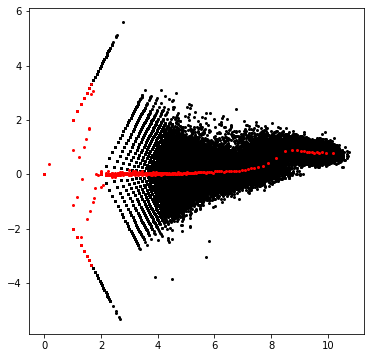

In [58]:
def Scatter_df_plot (_df, _col1, _col2):
    ## this is a similar approach as LOESS Normalization
    df_test = _df
    n_bins = 1000
    df_test['A'] = 0.5*(np.log2(df_test[_col1]) + np.log2(df_test[_col2])).rank(method='first') ## A is the value for MA plot 
    
    df_test['label'] = pd.qcut(df_test['A'].values, q=np.arange(0,1+1/n_bins, 1/n_bins),
                               labels = np.arange(0,n_bins))#, duplicates='drop')
    df_group = df_test.groupby('label')
    df_out = pd.DataFrame()
    df_line = []
    for df_for_norm in df_group:
        df_bbb = df_for_norm[1]
        df_line.append([ 0.5*(np.log2(df_bbb[_col1]) + np.log2(df_bbb[_col2])).mean(),
                         (np.log2(df_bbb[_col1])-np.log2(df_bbb[_col2])).mean()])
        
        df_out = df_out.append(df_bbb)
        
    df_test = df_out
    M = np.log2(df_test[_col1])-np.log2(df_test[_col2])
    A = 0.5*( np.log2(df_test[_col1]) + np.log2(df_test[_col2]))
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 

    plt.plot(A, M, 'ko', ms=2)
    df_line = pd.DataFrame(data=df_line)
    x = df_line[0]
    y = df_line[1]
    plt.plot(x, y, 'ro', ms=2)
    plt.show() 
    
    return None

Scatter_df_plot(df_out, col_fore, col_back)

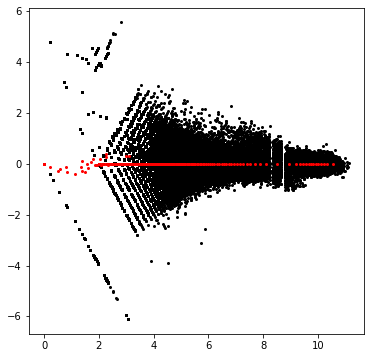

In [59]:
def LOESS_Norm_Scatter_plot (_df, _col1, _col2):
    ## this is a similar approach as LOESS Normalization
    df_test = _df
    n_bins = 1000
    df_test['A'] = 0.5*(np.log2(df_test[_col1]) + np.log2(df_test[_col2])).rank(method='first') ## A is the value for MA plot 
    
    df_test['label'] = pd.qcut(df_test['A'].values, q=np.arange(0,1+1/n_bins, 1/n_bins),
                               labels = np.arange(0,n_bins))#, duplicates='drop')
    df_group = df_test.groupby('label')
    df_out = pd.DataFrame()
    df_line = []
    for df_for_norm in df_group:
        df_bbb = df_for_norm[1]
        sum_1 = df_bbb[_col1].sum(axis=0)
        sum_2 = df_bbb[_col2].sum(axis=0)
        df_bbb[_col2] = round(df_bbb[_col2]/sum_2*sum_1, 2)
        df_out = df_out.append(df_bbb)
        df_line.append([ 0.5*(np.log2(df_bbb[_col1]) + np.log2(df_bbb[_col2])).mean(),
                 (np.log2(df_bbb[_col1])-np.log2(df_bbb[_col2])).mean()])
    
    df_test = df_out
    M = np.log2(df_test[_col1])-np.log2(df_test[_col2])
    A = 0.5*( np.log2(df_test[_col1]) + np.log2(df_test[_col2]))
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 

    plt.plot(A, M, 'ko', ms=2)
    df_line = pd.DataFrame(data=df_line)
    x = df_line[0]
    y = df_line[1]
    plt.plot(x, y, 'ro', ms=2)
    plt.show()   
    
    return None

LOESS_Norm_Scatter_plot(df_out, col_fore, col_back)

## Differential Hub associated with Features

In [66]:
# Data Analysis
import numpy as np
import pandas as pd
import os
from pybedtools import BedTool

# Plot Package
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline
from scipy import stats

In [89]:
def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value']].fillna('')

def feature_associated_genes(gene_annotation_path, feature_path):
    gene_annotation_Bed=BedTool(gene_annotation_path).sort()
    features_Bed=BedTool(feature_path).sort()
    
    #########################################################################################
    ## pre step remove the one overlap with DEGs promoter
    #feature_DEGs_Promoter=BedTool('313_259_DEGs_Promoter_Regions_ext_1kb.bed')
    #features_Bed = features_Bed.intersect(feature_DEGs_Promoter, u=True)
    #########################################################################################
    ### first association by overlap
    features_associated_genes = features_Bed.intersect(gene_annotation_Bed, wa=True, wb=True)
    df_all_group = pd.read_table(features_associated_genes.fn, header=None)
    ### Second associate rest features by cloest
    #features_no_overlap = features_Bed.intersect(gene_annotation_Bed,v=True)
    #if (features_no_overlap.count()!=0):
    #    features_closest_associated=features_no_overlap.closest(gene_annotation_Bed, t='all')
    #    df_features_closest_associated=pd.read_table(features_closest_associated.fn, header=None)
    #    df_all_group = df_all_group.append(df_features_closest_associated)
    
    return df_all_group

def box_plot_for_haihui(all_data, y_axis_name):
    ### Define Boxplot FrameSize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.1+len(all_data)*1.2, 4.6))
    x_rotation=-60
    
    plt.xticks(rotation=x_rotation)
    
    ax.boxplot( all_data, showfliers=False, widths=0.3,
           boxprops=dict(linestyle='-', linewidth=1.5, color='black'), 
           whiskerprops = dict(linestyle='-', linewidth=1.5, color='black'),
           capprops = dict(linestyle='-', linewidth=1.5, color='black'),
           medianprops = dict(linestyle='-', linewidth=1.5, color='red'))
    
    ### Generate X ticks
    xtiks = []
    for i in range(len(all_data)):
        xtiks.append(len(all_data[i]))
        
    plt.setp(ax, xticks=[y + 1 for y in range(len(all_data))], xticklabels=xtiks)



    ### plot size
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_label_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='x',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='x',which='minor', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='minor', direction='out', length=6, labelsize=18, width=1.5)

    ax.set_ylabel(y_axis_name, fontsize = 16, fontname="Arial")
    ax.locator_params(nbins=5, axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return None

## Figure24
### A

P_value is: 1.2e-18


/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


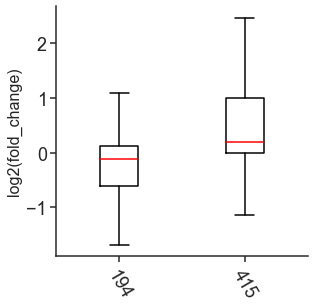

In [98]:
## CD8 HP
Feature_Path = '/home/xli/Data/Haihui/CD8-HP/Summary/' 
Path_Gene = Feature_Path+'gene_promoter_1k_iv_unique.bed'

PATH_WT_Hub=Feature_Path+ '68_top_WT_na_regions.bed'
PATH_DKO_Hub=Feature_Path+ '169_top_DKO_na_regions.bed'
#df_enhancer = pd.read_csv(PATH_Enhancer,sep='\t')

further_cutoff = 20

df_WT_SE = pd.read_csv(PATH_WT_Hub, sep='\t')
df_WT_SE['label']='WT'
df_WT_SE = df_WT_SE[df_WT_SE['-log10(pvalue)']>further_cutoff]
feature_WT_SE = BedTool.from_dataframe(df_WT_SE).sort()

df_DKO_SE = pd.read_csv(PATH_DKO_Hub, sep='\t')
df_DKO_SE['label']='DKO'
df_DKO_SE = df_DKO_SE[df_DKO_SE['-log10(pvalue)']>further_cutoff]
feature_DKO_SE = BedTool.from_dataframe(df_DKO_SE).sort()


def feature_associated_genes(gene_annotation_path, feature_path):
    df_gene = pd.read_csv(gene_annotation_path, sep='\t')
    df_feature = pd.read_csv(feature_path, sep='\t')
    gene_annotation_Bed=BedTool.from_dataframe(df_gene).sort()
    features_Bed=BedTool.from_dataframe(df_feature).sort()
    features_associated_genes = features_Bed.intersect(gene_annotation_Bed, wa=True, wb=True)
    df_all_group = pd.read_table(features_associated_genes.fn, header=None, names=(df_feature.columns).append(df_gene.columns+'_g'))

    return df_all_group

PATH_Expression = '/home/xli/Data/Haihui/CD8-HP/RNAseq/Cuffdiff_Results/DKO_0h_vs_WT_0h'
df_gene_expression = generate_All_Genes(PATH_Expression,0)


feature_path=PATH_WT_Hub
df_feature_associated_genes_WT_specific=feature_associated_genes(Path_Gene, feature_path)
feature_path=PATH_DKO_Hub
df_feature_associated_genes_DKO_specific = feature_associated_genes(Path_Gene, feature_path)


df_feature_associated_genes= df_feature_associated_genes_WT_specific.append(df_feature_associated_genes_DKO_specific).rename(columns={'reg1':'Diff_Hub', 6:'label'})
df_feature_associated_genes = df_feature_associated_genes.merge(df_gene_expression, left_on='gene_id_g', right_on='gene_id', how='inner')


df_feature_associated_genes['expression']= 'Null'
#df_feature_associated_genes[10].apply(
#    lambda x: 'up' if x in list(df_RPKM_up['gene_id']) else ( 'down' if x in list(df_RPKM_down['gene_id']) else 'Null'))
#df_feature_associated_genes_with_genes=df_feature_associated_genes[df_feature_associated_genes['expression']!='Null'].sort_values(by=['expression','SuperEnhancer'], ascending=False)
df_feature_associated_genes_with_genes = df_feature_associated_genes
df_feature_associated_genes=df_feature_associated_genes.loc[:,['0','1','2','Diff_Hub', 'label', 'gene_id','log2(fold_change)' ]].drop_duplicates().sort_values(by =['log2(fold_change)','Diff_Hub'], ascending=[False,True]).reset_index().drop('index',axis=1)

## 
pvalue = 1
df_feature_associated_genes_with_genes = df_feature_associated_genes_with_genes[df_feature_associated_genes_with_genes['p_value']<=pvalue]
df_group = df_feature_associated_genes_with_genes.groupby('Diff_Hub')
#df_group = df_feature_associated_genes.groupby(3)


df_plot = df_feature_associated_genes_with_genes#.head(2)
#df_plot['log2(fold_change)'] = np.log2(df_plot['H1-hESC'].replace(0,0.1)/df_plot['HFFc6'].replace(0,0.1))
all_data = [
df_plot[df_plot['label']=='WT'].loc[:, 'log2(fold_change)'],
df_plot[df_plot['label']=='DKO'].loc[:, 'log2(fold_change)']
]

y_axis_name = 'log2(fold_change)'
box_plot_for_haihui(all_data, y_axis_name)

pvalue=stats.mannwhitneyu(all_data[0], all_data[1], alternative='less')[1]
print('P_value is: %.1e' % pvalue )

#print ("26 Genes: WT_Specific_Hub   44 Genes: DKO_Specific_Hub")

### Figure24.B

WT
DKO


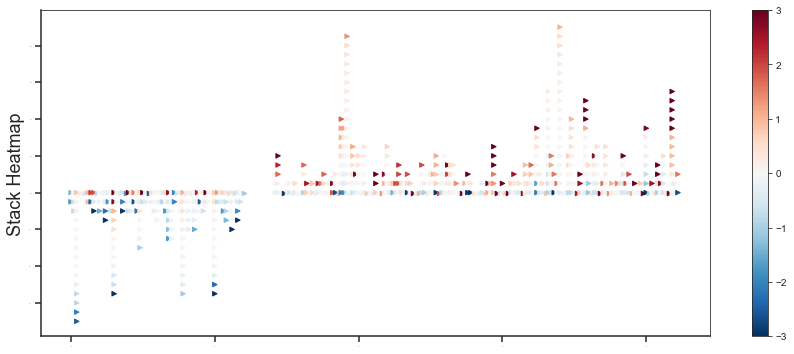

In [97]:
## CD8 Associated Genes

Feature_Path = '/home/xli/Data/Haihui/CD8-HP/Summary/' 
Path_Gene = Feature_Path+'gene_promoter_1k_iv_unique.bed'
PATH_WT_Hub=Feature_Path+ '68_top_WT_na_regions.bed'
PATH_DKO_Hub=Feature_Path+ '169_top_DKO_na_regions.bed'
df_RB = pd.read_csv(PATH_WT_Hub, sep='\t')
df_RB['label']='WT'
df_AB = pd.read_csv(PATH_DKO_Hub, sep='\t')
df_AB['label']='DKO'

Input_Path = '/home/xli/Data/Haihui/CD8-HP/RNAseq/Cuffdiff_Results/DKO_0h_vs_WT_0h/'
df_expression = generate_All_Genes(Input_Path, 0)
df_expression['log2(fold_change)'] = np.log2(df_expression['DKO_0h'].replace(0,0.1)/df_expression['WT_0h'].replace(0,0.1))
#df_expression = df_expression[df_expression.loc[:, 'p_value']<0.05]

#df_expression = df_expression[(df_expression['log2(fold_change)']>1)|(df_expression['log2(fold_change)']<-1)]
df_enhancer = pd.read_csv(Path_Gene,sep='\t').merge(df_expression.loc[:, ['gene_id','log2(fold_change)']], on='gene_id', how='inner')

Feature_Enhancer = BedTool.from_dataframe(df_enhancer).sort()



df_feature_associated_genes_WT_specific=feature_associated_genes(PATH_WT_Hub, Path_Gene)
df_feature_associated_genes_WT_specific['label']='WT'
df_feature_associated_genes_DKO_specific = feature_associated_genes(PATH_DKO_Hub, Path_Gene)
df_feature_associated_genes_DKO_specific['label']='DKO'
df_feature_associated_genes= df_feature_associated_genes_WT_specific.append(df_feature_associated_genes_DKO_specific)
df_feature_associated_genes = df_feature_associated_genes.merge(df_expression.loc[:, ['gene_id','log2(fold_change)']], on='gene_id', how='inner')

col_for_regions = 'reg1_g'
col_for_plot = 'log2(fold_change)'#'log2_FC'
df_group = df_feature_associated_genes.groupby(col_for_regions)


### version 1
target_SE = df_feature_associated_genes[col_for_regions].unique()
i=0

#Plot_id_Set={'DKO_SE': df_DKO_SE.sort_values('logFC').GeneID.values} 
Plot_id_Set={'WT': df_RB.sort_values('-log10(pvalue)').reg1.values, 'DKO': df_AB.sort_values('-log10(pvalue)').reg1.values} #

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

#df_gene_expression_tem.sort_values('log2(fold_change)')['gene_id']

for gene_set_name in Plot_id_Set.keys():
    print (gene_set_name)
    for group_name in Plot_id_Set[gene_set_name]:
        #print (group_name)
        if(group_name not in target_SE):
            continue
        else:
            group_item=df_group.get_group(group_name)
            sort_col = col_for_regions
            if (gene_set_name=='WT'):
                group_item=group_item.sort_values(col_for_plot, ascending=False)
                y_coordinate=-np.arange(len(group_item[sort_col]))/20
                x_coordinate=np.zeros(len(group_item[sort_col]))
            else:
                group_item=group_item.sort_values(col_for_plot, ascending=True)
                y_coordinate=np.arange(len(group_item[sort_col]))/20
                x_coordinate=np.zeros(len(group_item[sort_col]))+10
                
            SE_fc = 0#group_item[sort_col].values[0]
            im = ax.scatter(x_coordinate+i, y_coordinate+SE_fc, c=group_item[col_for_plot],
                        vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
            i+=1
    #ax.set_title(str(len(Plot_id_Set[gene_set_name]))+'_'+ gene_set_name, fontsize=12)#, color='r')   
#ax.plot(np.arange(i),np.zeros(i), '--', linewidth=1)
ax.set_ylabel('Stack Heatmap', fontsize='18')
#ax.legend([im], ['Genes'], scatterpoints=1,loc=0, fontsize=14)
fig.colorbar(im,ax=ax)


ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

ax.tick_params(axis='both',which='minor', direction='in', length=4)
ax.tick_params(axis='both',which='major', direction='inout', length=10)
    ### plot size
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_label_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_label_position("left")

ax.tick_params(axis='x',which='major', direction='out', length=6, labelsize=0, width=1.5)
ax.tick_params(axis='x',which='minor', direction='out', length=6, labelsize=0, width=1.5)
ax.tick_params(axis='y',which='major', direction='out', length=6, labelsize=0, width=1.5)
ax.tick_params(axis='y',which='minor', direction='out', length=6, labelsize=0, width=1.5)
